# Imports

In [1]:
import sys
import os
import numpy as np
RT_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src"
BA_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/basic_application/src"
sys.path.append(RT_LIBS_PATH)
sys.path.append(BA_LIBS_PATH)

In [2]:
from data_providers import ClickHouseConnector
from data_providers import DbDataProviderRT5

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from train_tools import plot_and_go
from basic_application import with_debug_time

%matplotlib notebook
db_connect_params = {
    "host" : "194.87.210.189",
    "port" : 59000,
    "user" : "alex",
    "password" : "Xrxcmr758",
    "database" : "rt5"
}

2023-05-31 22:28:53.289956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
%matplotlib notebook

In [4]:
symbols = [ "BTC_USDT", "ETH_USDT", "USDD_USDT", "TRX_USDT", "BTT_USDT", "NFT_USDT", "XRP_USDT",
             "ETH_BTC", "XRP_BTC", "TRX_BTC", "LTC_BTC", "EOS_BTC", "XMR_BTC", "DOGE_BTC",
             "NFT_TRX", "ETH_TRX", "JST_TRX", "XRP_TRX",
             "ETHBULL_USDT", "BULL_USDT", "BEAR_USDT", "ADABULL_USDT" ]

# Загрузка единого датасета

Cursor created, database connection established
Cursor closed


<IPython.core.display.Javascript object>


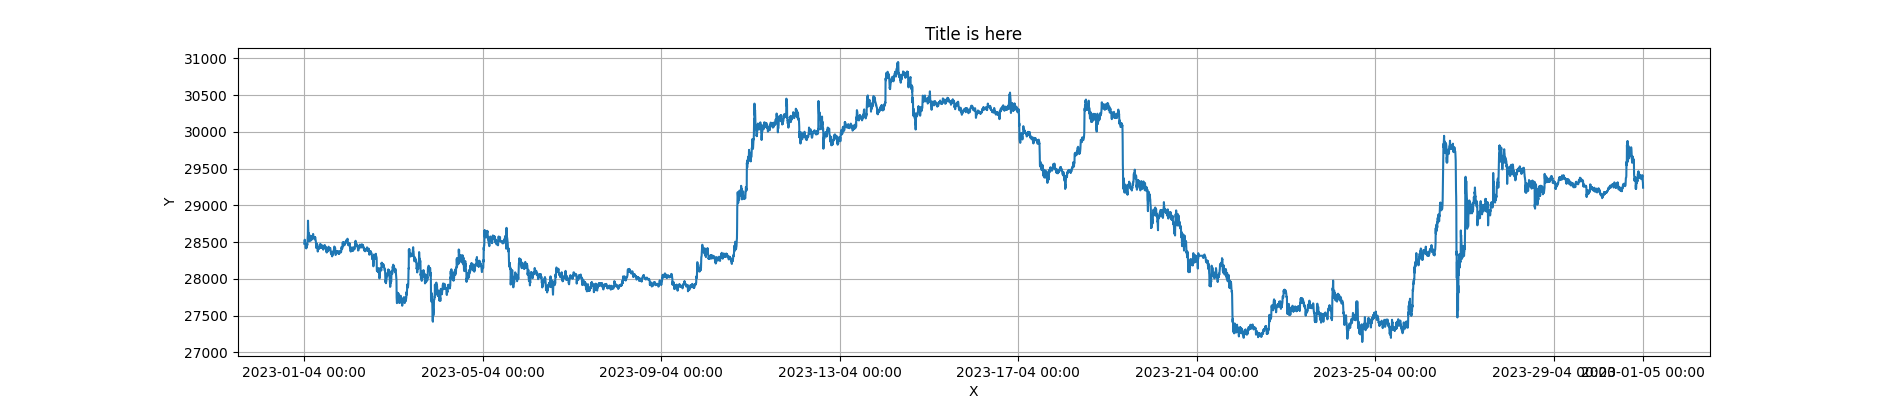

(8639, 11)


In [32]:
pair = "BTC_USDT"
start = "2023-04-01 00:00:00"
end = "2023-04-30 23:59:59"
period = 300

with ClickHouseConnector(db_connect_params) as connector:
    
    data_provider = DbDataProviderRT5(connector)
    data = data_provider.get_by_time(start, end, period, pair, fill_gaps=True)
    
plot_and_go(data, fig_x=19, fig_y=4, dpi=50)

In [7]:
# Проверка на 0
(data[["lowest_ask"]]==0).any(axis=1).sum()

127

In [8]:
data.drop(data[data.lowest_ask==0].index, inplace=True)

<IPython.core.display.Javascript object>


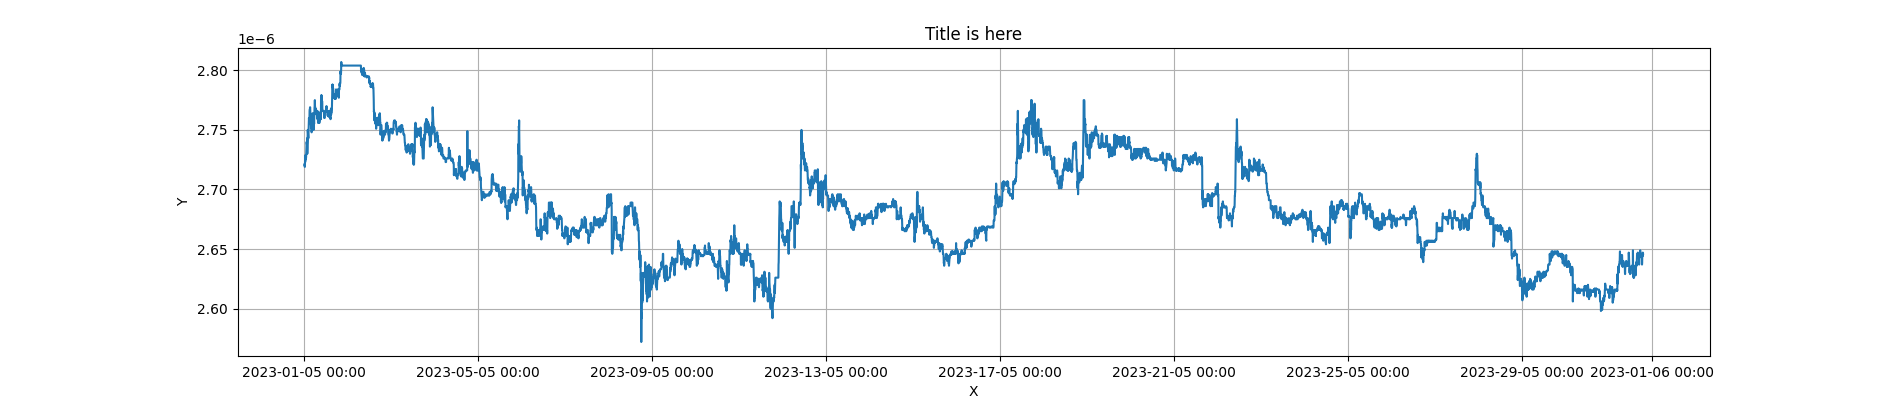

(8740, 11)


In [9]:
plot_and_go(data, fig_x=19, fig_y=4, dpi=50)

# Сохранение

In [15]:
category = "rt5"
dataset_name = "13." + pair

path = "datasets/{0}".format(category)

if not os.path.exists(path):
    os.makedirs(path)
        
full_path = os.path.join(path, "{0}-{1}.csv".format(dataset_name, period))    
data.to_csv(full_path)

print(full_path)

datasets/rt5/13.ETH_USDT-300.csv


# Загрузка и сохранение в цикле

In [16]:
category = "rt5"
path = "datasets/{0}".format(category)
if not os.path.exists(path):
    os.makedirs(path)

In [27]:
symbols = [ "BTC_USDT", "ETH_USDT", "TRX_USDT", "NFT_USDT", "XRP_USDT",
            "ETH_BTC", "XRP_BTC", "TRX_BTC", "LTC_BTC", "EOS_BTC", "XMR_BTC", "DOGE_BTC"]

#symbols = [ "BTC_USDT", "ETH_USDT"]

In [36]:
start = "2023-04-01 00:00:00"
end = "2023-04-30 23:59:59"
period = 60

dataset_name = "14."


with ClickHouseConnector(db_connect_params) as connector:
    data_provider = DbDataProviderRT5(connector)
    for symbol in symbols:
        data = data_provider.get_by_time(start, end, period, symbol, fill_gaps=False)
        
        gaps = (data[["lowest_ask"]]==0).any(axis=1).sum()
        if gaps < 350:
            data.drop(data[data.lowest_ask==0].index, inplace=True)
            full_path = os.path.join(path, "{0}-{1}.csv".format(dataset_name + symbol, period))    
            data.to_csv(full_path)

            print(f"{symbol} saved")
        else:
            print(f"{symbol} passed, has {gaps} gap(s)")
    
    

Cursor created, database connection established


BTC_USDT saved
ETH_USDT saved
TRX_USDT saved
NFT_USDT saved
XRP_USDT saved
ETH_BTC saved
XRP_BTC saved
TRX_BTC saved
LTC_BTC saved
EOS_BTC saved
XMR_BTC saved


Cursor closed


DOGE_BTC saved


# Загрузка датасета (train/test) с историей

In [10]:
def get_dataset(start, end, period, pair):
    with ClickHouseConnector(db_connect_params) as connector:
        data_provider = DbDataProviderRT5(connector)
        data = data_provider.get_by_time(start, end, period, pair, fill_gaps=False)
    plot_and_go(data, fig_x=19, fig_y=4, dpi=50)
    return data

In [15]:
pair = "BTC_USDT"
period = 300 

obs_len = 30
scale_factor = np.array([1, 3, 6])
max_period = max(scale_factor) * period                       
history_size = max_period * obs_len
print("Длина истории в часах: {0} ({1:.1f} дней)".format(history_size//3600, history_size//3600/24))
print("Количество точек данных в истории: {0}".format(history_size//period))
print("Формат данных для observation_builder {0}".format(scale_factor))

Длина истории в часах: 15 (0.6 дней)
Количество точек данных в истории: 180
Формат данных для observation_builder [1 3 6]


## Превью данных

Cursor created, database connection established
Cursor closed


<IPython.core.display.Javascript object>


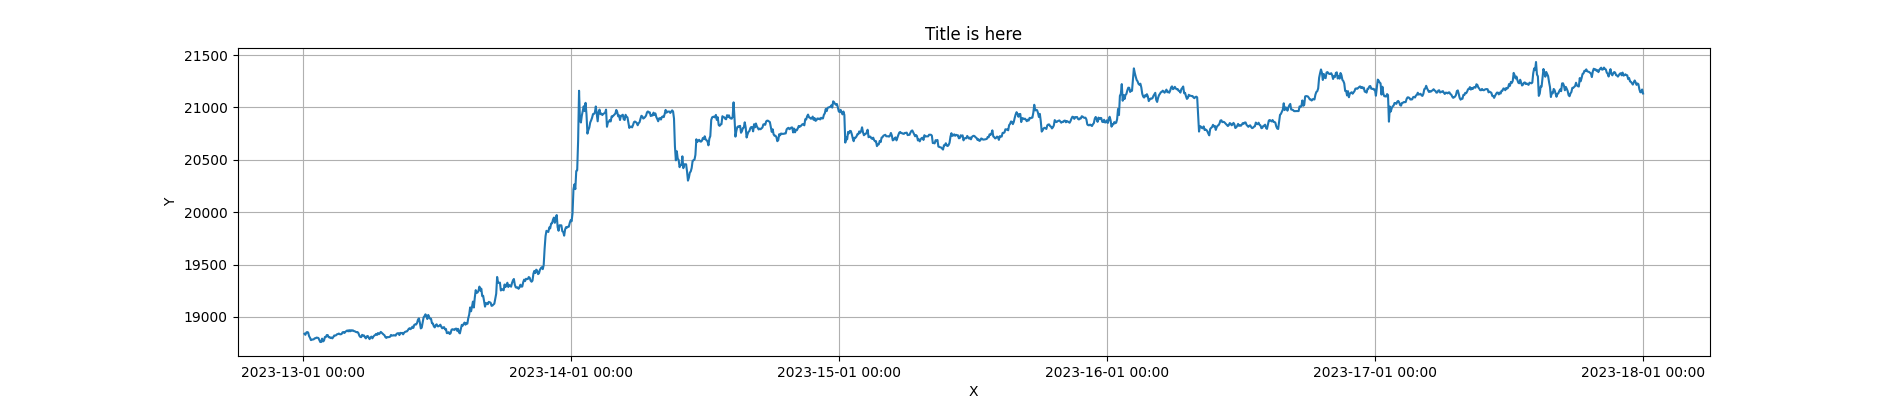

(1439, 11)


In [17]:
#старые значения
start_train = "2023-01-13 00:00:00"
end_train = "2023-01-17 23:59:00"


#start_train = "2022-10-01 22:00:00"
#end_train = "2022-10-14 23:59:59"

data_train = get_dataset(start_train, end_train, period, pair)

Cursor created, database connection established
Cursor closed


<IPython.core.display.Javascript object>


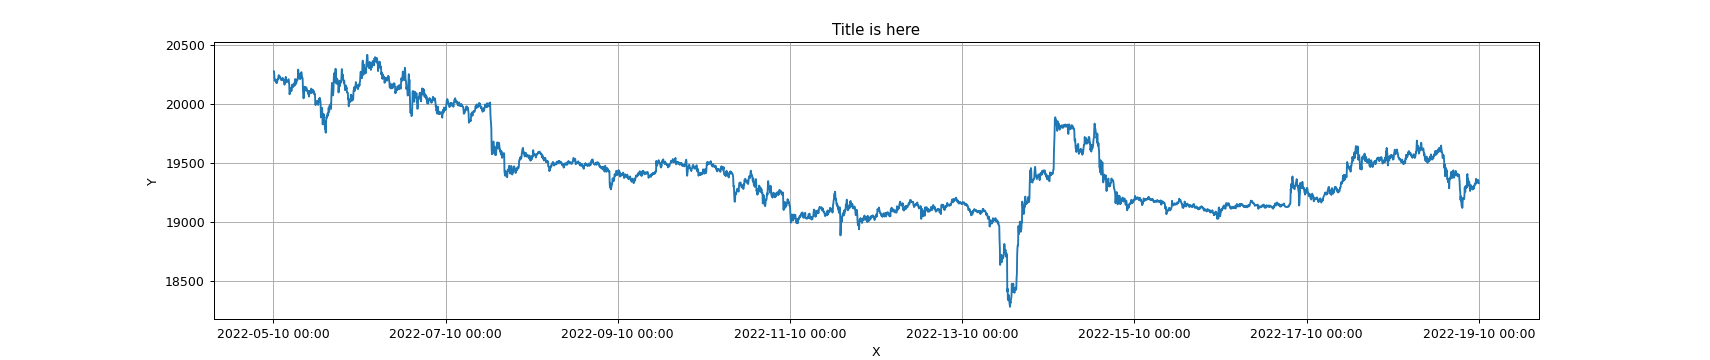

(4031, 11)


In [21]:
#старые значение
start_test = "2022-09-08 12:00:00"
end_test = "2022-09-15 23:59:59"

start_test = "2022-10-05 00:00:00"
end_test = "2022-10-18 23:59:59"

data_test = get_dataset(start_test, end_test, period, pair)

## Загрузка данных

Cursor created, database connection established
Cursor closed


<IPython.core.display.Javascript object>


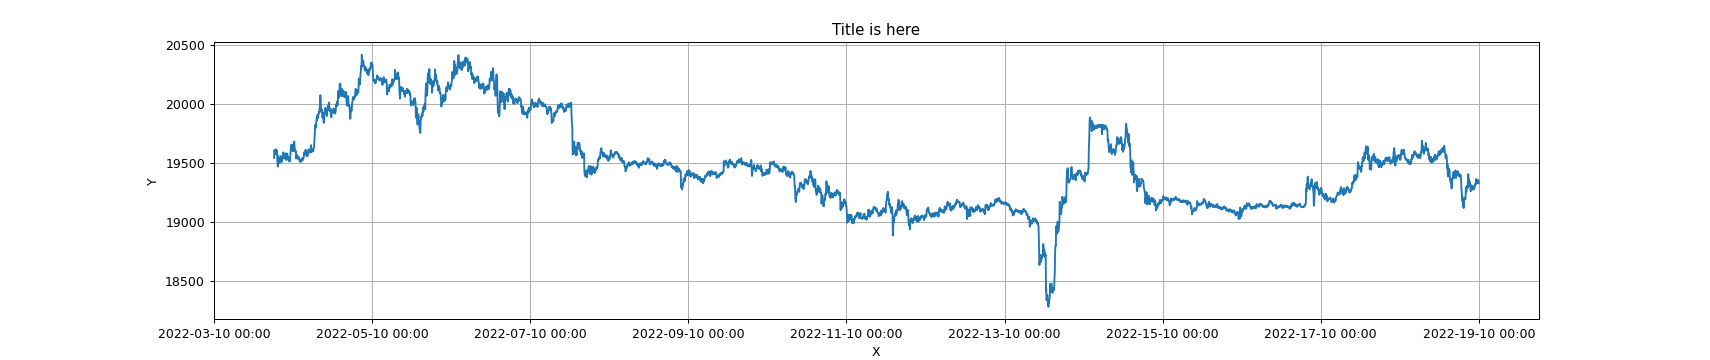

(4391, 11)


In [22]:
#start_train_ts = DbDataProviderRT5.date_to_unix_ts_in_utc(start_train) - history_size
#end_train_ts = DbDataProviderRT5.date_to_unix_ts_in_utc(end_train)
#data_train = get_dataset(start_train_ts, end_train_ts, period, pair)

start_test_ts = DbDataProviderRT5.date_to_unix_ts_in_utc(start_test) - history_size
end_test_ts = DbDataProviderRT5.date_to_unix_ts_in_utc(end_test)
data_test = get_dataset(start_test_ts, end_test_ts, period, pair)

# Сохранение

In [23]:
category = "rt5"
dataset_name = "03.BTC_USDT"

path = "datasets/{0}".format(category)

if not os.path.exists(path):
    os.makedirs(path)
        
#full_path_train = os.path.join(path, "{0}-{1}-train.csv".format(dataset_name, period))    
#data_train.to_csv(full_path_train)

full_path_test = os.path.join(path, "{0}-{1}-test2.csv".format(dataset_name, period))    
data_test.to_csv(full_path_test)

#print(full_path_train)
print(full_path_test)

datasets/rt5/03.BTC_USDT-300-test2.csv


# Немного визуализации

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

In [423]:
import json

# Визуализация

Cursor created, database connection established
Cursor closed


<IPython.core.display.Javascript object>


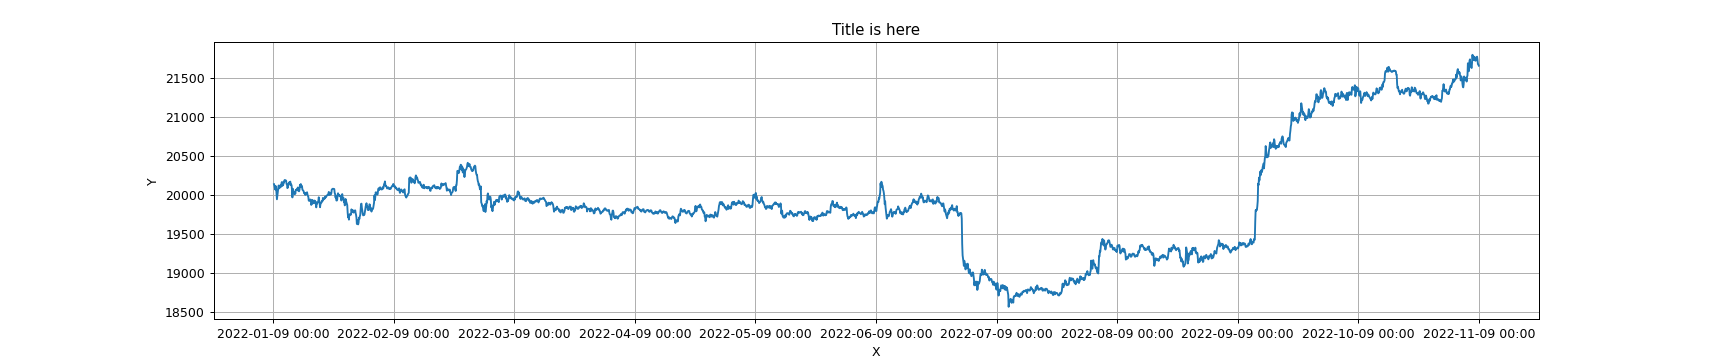

(2879, 11)


In [620]:
pair = "BTC_USDT",
start = "2022-08-30 10:00:00"
end = "2022-09-09 05:00:00"

# данные для анализа зависимостей
start = "2022-09-01 00:00:00"
end = "2022-09-10 23:59:59"


period = 300 

with ClickHouseConnector(db_connect_params) as connector:
    
    data_provider = DbDataProviderRT5(connector)
    data = data_provider.get_by_time(start, end, period, pair, fill_gaps=False)
    
    
plot_and_go(data, fig_x=19, fig_y=4, dpi=50)

In [621]:
n_steps = 2
def diff_func(x):
    return x.iloc[-1] - x.iloc[0]

data['highest_bid_diff'] = data['highest_bid'].rolling(window=n_steps).apply(diff_func)


In [851]:
LEVELS = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.02]
def _get_volumes(asks, bids, lowest_ask, highest_bid):
    
    if len(asks) and len(bids):
        keys_asks = np.array(list(map(float, asks.keys())))
        vols_asks = np.array(list(map(float, asks.values())))
        
        keys_bids = np.array(list(map(float, bids.keys())))
        vols_bids = np.array(list(map(float, bids.values())))
        
        asks_ = []
        bids_ = []

        for coef in LEVELS:
            mask_ask = keys_asks < lowest_ask * (1 + coef)
            asks_.append(sum(vols_asks[mask_ask]))
            
            mask_bid = keys_bids > highest_bid * (1 - coef)
            bids_.append(sum(vols_bids[mask_bid]))
    else:
        asks_ = np.zeros(len(LEVELS))
        bids_ = np.zeros(len(LEVELS))

    return np.array(asks_), np.array(bids_)

In [962]:
idxs = data.index.values

l = len(idxs) - 1
result_a = list()
result_b = list()
result_a.append(np.zeros(len(LEVELS)))
result_b.append(np.zeros(len(LEVELS)))

for i in range(l):
    idx_curr = idxs[i+1]
    idx_prev = idxs[i]
    
    row_curr = data.loc[idx_curr, :]
    row_prev = data.loc[idx_prev, :]
    
    asks_curr = row_curr["asks"] # json.loads(row_curr["asks"].replace("\'", "\""))
    asks_prev = row_prev["asks"]
    bids_curr = row_curr["bids"]
    bids_prev = row_prev["bids"]
    
    if len(asks_curr) and len(asks_prev):
        lowest_ask = np.min(np.array(list(map(float, asks_curr.keys()))))
        highest_bid = np.max(np.array(list(map(float, bids_curr.keys()))))
        
        asks_prev_vol, bids_prev_vol = _get_volumes(asks_prev, bids_prev, lowest_ask, highest_bid)
        asks_curr_vol, bids_curr_vol = _get_volumes(asks_curr, bids_curr, lowest_ask, highest_bid)
        
        result_a.append(asks_prev_vol-asks_curr_vol)
        result_b.append(bids_prev_vol-bids_curr_vol)
    else:
        result_a.append(np.zeros(len(LEVELS)))
        result_b.append(np.zeros(len(LEVELS)))
        
asks_col_names = ['asks_' + col for col in map(str, LEVELS)]
bids_col_names = ['bids_' + col for col in map(str, LEVELS)]    
    

In [965]:
len(idxs)

2879

In [853]:
data_asks = pd.DataFrame(np.array(result_a), columns=asks_col_names, index=data.index)
data_bids = pd.DataFrame(np.array(result_b), columns=bids_col_names, index=data.index)

data_full = pd.merge(data, data_asks, left_index=True, right_index=True)
data_full = pd.merge(data_full, data_bids, left_index=True, right_index=True)

for level in map(str, LEVELS):
    data_full["diff_" + level] = data_full["asks_" + level] - data_full["bids_"+level]
    data_full["adiff_" + level] = data_full["asks_" + level] + data_full["bids_"+level]

In [854]:
data_full.head(3)

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,...,diff_0.0025,adiff_0.0025,diff_0.005,adiff_0.005,diff_0.0075,adiff_0.0075,diff_0.01,adiff_0.01,diff_0.02,adiff_0.02
ts,,,,,,,,,,,,,,,,,,,,,
1661990999,2022-09-01 00:09:59,20135.189453,20135.179688,"{'20135.19': 0.279899, '20135.27': 0.28, '2013...","{'20135.18': 0.021221, '20135.14': 0.237659, '...",0.501872,0.430278,0.932150,20,15,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1661991299,2022-09-01 00:14:59,20117.861328,20112.291016,"{'20117.86': 0.02, '20119.71': 0.56, '20121.73...","{'20112.29': 0.558904, '20108.7': 0.1, '20108....",0.508077,0.368377,0.876454,20,24,...,-2.656345,0.974643,1.493655,2.424643,1.493655,2.424643,1.493655,2.424643,1.493648,2.424650
1661991599,2022-09-01 00:19:59,20088.189453,20088.179688,"{'20088.19': 0.56, '20090.81': 0.02, '20092.54...","{'20088.18': 0.56, '20084.49': 0.28, '20084.1'...",0.488169,0.216997,0.705166,22,14,...,-3.981714,-4.646388,-0.794289,-1.458963,-0.794289,-1.458963,-0.794289,-1.458963,-0.793277,-1.457975


<IPython.core.display.Javascript object>


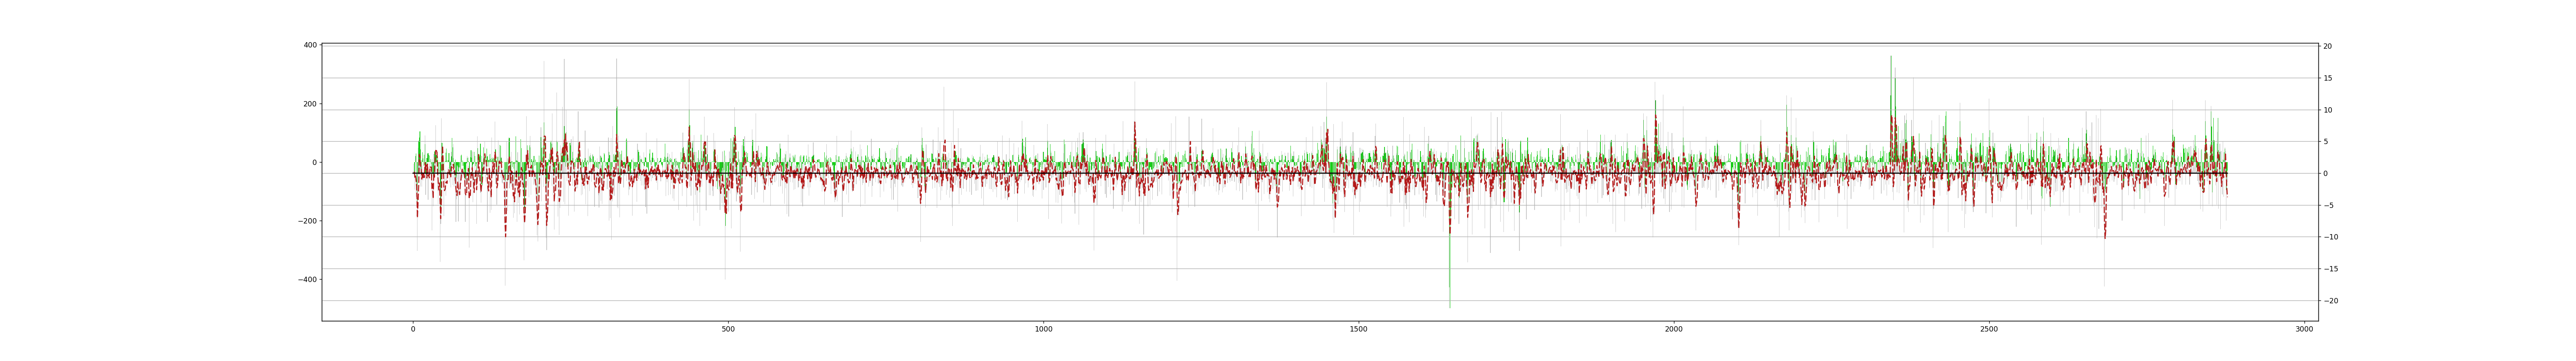

In [855]:
fig, ax = plt.subplots(figsize=(50,7), dpi=70)
ax2 = ax.twinx()
x_data = list(range(data_full.shape[0]))

#ax.plot(x_data, data_full["highest_bid"])

#ax2.plot(data_full["diff_0.0025"].rolling(5, center=False).mean(), color=(0.9, 0.3, 0.0))
#ax2.plot(data_full["diff_0.005"].rolling(5, center=False).mean(), color=(0.0, 0.9, 0.3))
#ax2.plot(data_full["diff_0.005"].rolling(10, center=False).mean(), color=(0.3, 0.3, 0.3))

#ax2.plot(data_full["diff_0.01"].rolling(3, center=False).mean(), color=(0.7, 0.4, 0.0))
#ax2.plot(data_full["diff_0.015"].rolling(3, center=False).mean(), color=(0.5, 0.3, 0.0))


#ax2.plot(data_full["diff_0.0025"].rolling(3, center=False).mean(), color=(0.1, 0.7, 0.7),  dashes=[6, 2])
#ax2.plot(data_full["diff_0.0025"].rolling(5, center=False).mean(), color=(0.7, 0.1, 0.1),  dashes=[6, 2])
#ax2.plot(data_full["diff_0.0025"].rolling(6, center=False).mean(), )

ax2.bar(x=x_data, height=data_full["diff_0.005"], color=(0.3, 0.3, 0.3), alpha=0.3)
ax2.plot(x_data, data_full["diff_0.005"].rolling(3, center=False).mean(), color=(0.7, 0.1, 0.1),  dashes=[6, 2])

ax.bar(x=x_data, height=data['highest_bid'].rolling(window=3).apply(diff_func), color=(0.1, 0.8, 0.1))









ax2.plot(x_data, np.zeros(len(data_full)), color="black")
ax2.grid(axis='both', which='both')


In [856]:
window = 50
feature = "diff_0.0075"

roll = -1

rate_norm = data['highest_bid'].values.mean()
feature_norm = data_full[feature].values.mean()


feature_data = data_full[feature].values #/ feature_norm
rates = data['highest_bid'].values #/ rate_norm
feature_data_shift = np.roll(feature_data, roll) #/feature_norm

feature_data_slide_mean = data_full[feature].rolling(window, center=False).mean().dropna().values #/feature_norm
rates_slide_mean = data['highest_bid'].values[window+roll: ] #/ rate_norm
feature_data_slide_mean_shift = np.roll(feature_data_slide_mean, roll) #/feature_norm

# = = = = = = = = = = = = = = = = 

c1 = np.corrcoef(feature_data, rates)
print("Дата as is: {0:.2f}".format(c1[0,1]))

c2 = np.corrcoef(feature_data_shift, rates)
print("Дата as is со сдвигом: {0:.2f}".format(c2[0,1]))

c3 = np.corrcoef(feature_data_slide_mean, rates_slide_mean)
print("Дата скользящее среднее: {0:.2f}".format(c3[0,1]))

c4 = np.corrcoef(feature_data_slide_mean_shift, rates_slide_mean)
print("Дата скользящее среднее со сдвигом: {0:.2f}".format(c4[0,1]))

Дата as is: 0.04
Дата as is со сдвигом: 0.02
Дата скользящее среднее: 0.37
Дата скользящее среднее со сдвигом: 0.36


<IPython.core.display.Javascript object>


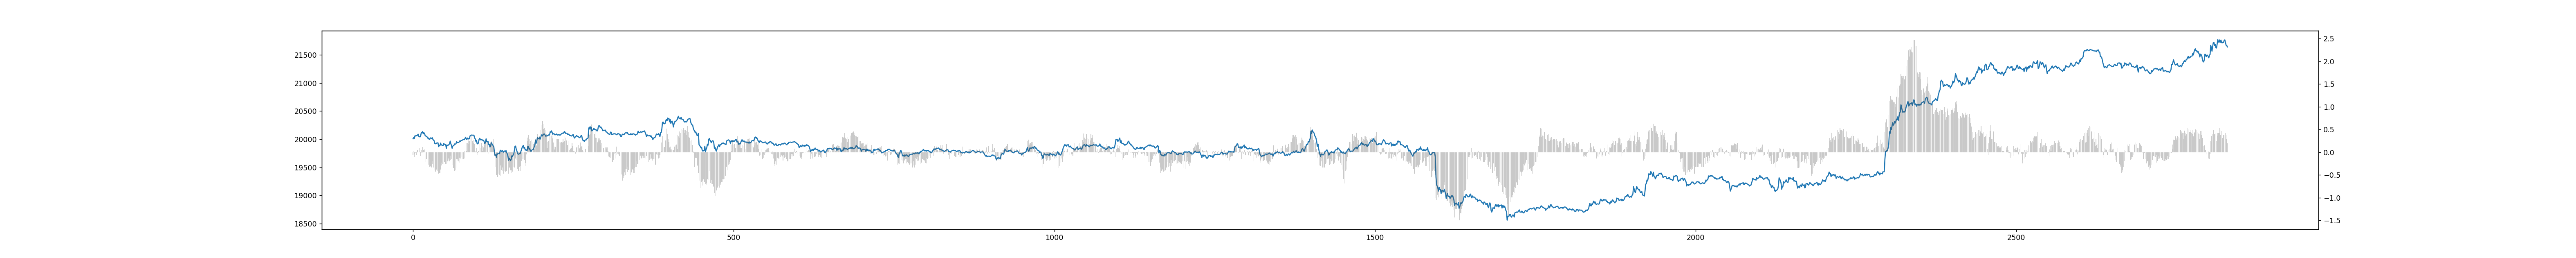

<BarContainer object of 2830 artists>

In [857]:
fig, ax = plt.subplots(figsize=(50,5), dpi=70)
ax2 = ax.twinx()

x_data = list(range(len(rates_slide_mean)))

ax.plot(x_data, rates_slide_mean)

ax2.bar(x=x_data, height=feature_data_slide_mean, color=(0.3, 0.3, 0.3), alpha=0.3)



In [1023]:
num = 10

In [1024]:
# 1. Получение датасета
data2 = data[:num]
idxs = data2.index.values
display(data2)

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,total_num,highest_bid_diff
ts,,,,,,,,,,,,
1661990999,2022-09-01 00:09:59,20135.189453,20135.179688,"{'20135.19': 0.279899, '20135.27': 0.28, '2013...","{'20135.18': 0.021221, '20135.14': 0.237659, '...",0.501872,0.430278,0.932150,20,15,35,NaN
1661991299,2022-09-01 00:14:59,20117.861328,20112.291016,"{'20117.86': 0.02, '20119.71': 0.56, '20121.73...","{'20112.29': 0.558904, '20108.7': 0.1, '20108....",0.508077,0.368377,0.876454,20,24,44,-22.888672
1661991599,2022-09-01 00:19:59,20088.189453,20088.179688,"{'20088.19': 0.56, '20090.81': 0.02, '20092.54...","{'20088.18': 0.56, '20084.49': 0.28, '20084.1'...",0.488169,0.216997,0.705166,22,14,36,-24.111328
1661991899,2022-09-01 00:24:59,20066.570312,20063.140625,"{'20066.57': 0.56, '20069.21': 0.29, '20072.06...","{'20063.14': 0.28, '20060.5': 0.28, '20058.5':...",0.871273,0.385815,1.257088,20,10,30,-25.039062
1661992199,2022-09-01 00:29:59,20111.289062,20109.259766,"{'20111.29': 0.56, '20113.31': 0.28, '20115.79...","{'20109.26': 0.56, '20104.94': 0.28, '20102.92...",0.768722,0.610555,1.379277,14,13,27,46.119141
1661992499,2022-09-01 00:34:59,20094.128906,20091.589844,"{'20094.13': 0.56, '20100.01': 0.28, '20102.02...","{'20091.59': 0.56, '20089.33': 0.28, '20086.4'...",0.439164,0.968704,1.407868,19,13,32,-17.669922
1661992799,2022-09-01 00:39:59,20017.949219,20017.080078,"{'20017.95': 0.28, '20018.64': 0.56, '20020.66...","{'20017.08': 0.56, '20016.07': 0.28, '20015.07...",0.246794,0.451029,0.697823,11,24,35,-74.509766
1661993099,2022-09-01 00:44:59,19941.570312,19941.560547,"{'19941.57': 0.56, '19947.33': 0.56, '19955': ...","{'19941.56': 0.56, '19929.98': 0.15, '19929.97...",1.191191,1.151373,2.342564,40,39,79,-75.519531
1661993399,2022-09-01 00:49:59,19983.169922,19980.160156,"{'19983.17': 0.56, '19988.67': 0.28, '19991.55...","{'19980.16': 0.56, '19977.06': 0.53, '19975.98...",1.687178,0.569873,2.257051,45,22,67,38.599609


In [1040]:
# 2. Расчет asks и bids
def _get_volume(level, asks, bids, lowest_ask, highest_bid):    
    keys_asks = np.array(list(map(float, asks.keys())))
    vols_asks = np.array(list(map(float, asks.values())))
        
    keys_bids = np.array(list(map(float, bids.keys())))
    vols_bids = np.array(list(map(float, bids.values())))
        
        
    mask_ask = keys_asks < lowest_ask * (1 + level)
    ask_vol = sum(vols_asks[mask_ask])
        
    mask_bid = keys_bids > highest_bid * (1 - level)
    bid_vol = sum(vols_bids[mask_bid])
        
    return ask_vol, bid_vol


def convert_orderbook(data, level=0.0025):
    asks_vol_arr = []
    bids_vol_arr = []
    
    idxs = data.index.values
    
    index_length = len(idxs)
    for i in range(index_length-1):
        idx_curr = idxs[i+1]        
        asks_curr = data.loc[idx_curr, "asks"]
        bids_curr = data.loc[idx_curr, "bids"]

        idx_prev = idxs[i]      
        asks_prev = data.loc[idx_prev, "asks"]
        bids_prev = data.loc[idx_prev, "bids"]
        
        
        if len(asks_curr) and len(asks_prev) and len(bids_curr) and len(bids_prev):
            lowest_ask = np.min(np.array(list(map(float, asks_prev.keys()))))
            highest_bid = np.max(np.array(list(map(float, bids_prev.keys()))))
        
            ask_curr_vol, bid_curr_vol = _get_volume(level, asks_curr, bids_curr, lowest_ask, highest_bid)
            asks_vol_arr.append(ask_curr_vol)
            bids_vol_arr.append(bid_curr_vol)
        else:
        
            asks_vol_arr.append(0)
            bids_vol_arr.append(0)

    return np.array(asks_vol_arr), np.array(bids_vol_arr)

asks, bids = convert_orderbook(data2, level=0.0025)
print(asks)
print(bids)

[ 8.133888  9.260514  9.44655   1.12     11.638121  9.560074 18.123601
  0.84      2.242   ]
[3.203268 4.93793  3.44576  7.615171 4.598265 0.       0.       7.748777
 8.114082]


In [1041]:
# 3. Вычисление разницы между значениями внутри asks и bids
asks_diff = np.diff(asks)
bids_diff = np.diff(bids)

print(asks_diff)
print(bids_diff)

[  1.126626   0.186036  -8.32655   10.518121  -2.078047   8.563527
 -17.283601   1.402   ]
[ 1.734662 -1.49217   4.169411 -3.016906 -4.598265  0.        7.748777
  0.365305]


In [1042]:
# 4. Вычисление разница между asks и bids (diff)
diff = asks_diff - bids_diff
print(diff)

[ -0.608036   1.678206 -12.495961  13.535027   2.520218   8.563527
 -25.032378   1.036695]


In [1043]:
# 5. Усреднение diff 
feature = diff.mean()
print(feature)

-1.3503377500000002


In [990]:
d = dict(data["asks"].values[0])

In [995]:
np.array(map(str, d.keys()))

array(<map object at 0x7fd291c14640>, dtype=object)

Дата as is: 0.02
Cо сдвигом: 0.09


<IPython.core.display.Javascript object>


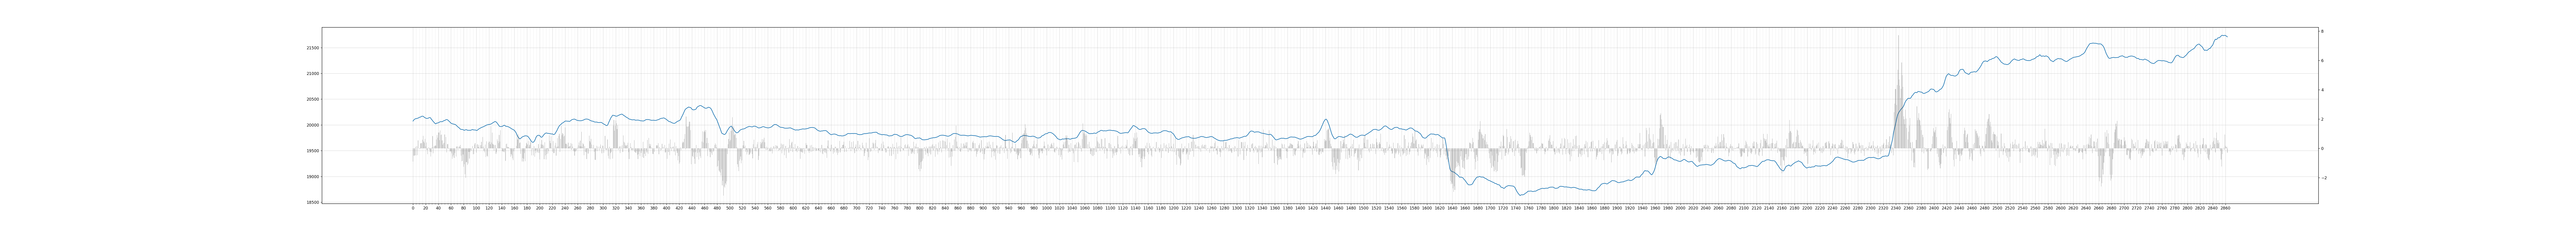

In [863]:
feature = "diff_0.01"

feat_window = 8
rates_window = 8

feature_data_shift = data_full[feature].rolling(feat_window, center=False).mean().dropna().values #/feature_norm
feature_data_shift = feature_data_shift[:-rates_window]

rates = data['highest_bid']
#rates = data['highest_bid'].rolling(window=2).apply(diff_func)
rates_data_shift = rates[feat_window:].rolling(rates_window, center=False).mean().dropna().values

c1 = np.corrcoef(data_full[feature], data['highest_bid'])
print("Дата as is: {0:.2f}".format(c1[0,1]))

c4 = np.corrcoef(feature_data_shift, rates_data_shift)
print("Cо сдвигом: {0:.2f}".format(c4[0,1]))


fig, ax = plt.subplots(figsize=(90,8), dpi=70)
ax2 = ax.twinx()
x_data = list(range(len(rates_data_shift)))
ax.plot(x_data, rates_data_shift)
ax2.bar(x=x_data, height=feature_data_shift, color=(0.3, 0.3, 0.3), alpha=0.3)
ax.grid(True)

major_ticks = np.arange(0, len(x_data)+1, 20)
minor_ticks = np.arange(0, len(x_data)+1, 5)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
#ax.set_yticks(major_ticks)
#ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)




In [832]:
s1 = np.array([0,1,2,3,4,5,6,7,8,9])
s2 = np.array([0,1,2,3,4,5,6,7,8,9])

In [833]:
w1 = 3
w2 = 2

In [834]:
s1[:-w2]

array([0, 1, 2, 3, 4, 5, 6, 7])

In [835]:
s2[w1:]

array([3, 4, 5, 6, 7, 8, 9])

In [872]:
cursor = 1661992199
n = 4

In [954]:
test_df = data_full.iloc[0:7, :]

In [955]:
test_df

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,...,diff_0.0025,adiff_0.0025,diff_0.005,adiff_0.005,diff_0.0075,adiff_0.0075,diff_0.01,adiff_0.01,diff_0.02,adiff_0.02
ts,,,,,,,,,,,,,,,,,,,,,
1661990999,2022-09-01 00:09:59,20135.189453,20135.179688,"{'20135.19': 0.279899, '20135.27': 0.28, '2013...","{'20135.18': 0.021221, '20135.14': 0.237659, '...",0.501872,0.430278,0.932150,20,15,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1661991299,2022-09-01 00:14:59,20117.861328,20112.291016,"{'20117.86': 0.02, '20119.71': 0.56, '20121.73...","{'20112.29': 0.558904, '20108.7': 0.1, '20108....",0.508077,0.368377,0.876454,20,24,...,-2.656345,0.974643,1.493655,2.424643,1.493655,2.424643,1.493655,2.424643,1.493648,2.424650
1661991599,2022-09-01 00:19:59,20088.189453,20088.179688,"{'20088.19': 0.56, '20090.81': 0.02, '20092.54...","{'20088.18': 0.56, '20084.49': 0.28, '20084.1'...",0.488169,0.216997,0.705166,22,14,...,-3.981714,-4.646388,-0.794289,-1.458963,-0.794289,-1.458963,-0.794289,-1.458963,-0.793277,-1.457975
1661991899,2022-09-01 00:24:59,20066.570312,20063.140625,"{'20066.57': 0.56, '20069.21': 0.29, '20072.06...","{'20063.14': 0.28, '20060.5': 0.28, '20058.5':...",0.871273,0.385815,1.257088,20,10,...,-7.602335,-2.811485,-2.581461,2.209389,-2.581461,2.209389,-2.581461,2.209389,-2.581460,2.209388
1661992199,2022-09-01 00:29:59,20111.289062,20109.259766,"{'20111.29': 0.56, '20113.31': 0.28, '20115.79...","{'20109.26': 0.56, '20104.94': 0.28, '20102.92...",0.768722,0.610555,1.379277,14,13,...,6.636393,-5.233949,2.574427,-1.171983,2.574427,-1.171983,2.574427,-1.171983,2.574421,-1.171977
1661992499,2022-09-01 00:34:59,20094.128906,20091.589844,"{'20094.13': 0.56, '20100.01': 0.28, '20102.02...","{'20091.59': 0.56, '20089.33': 0.28, '20086.4'...",0.439164,0.968704,1.407868,19,13,...,-6.075475,-4.426111,-3.717475,-2.068111,-3.717475,-2.068111,-3.717475,-2.068111,-3.717470,-2.068116
1661992799,2022-09-01 00:39:59,20017.949219,20017.080078,"{'20017.95': 0.28, '20018.64': 0.56, '20020.66...","{'20017.08': 0.56, '20016.07': 0.28, '20015.07...",0.246794,0.451029,0.697823,11,24,...,-10.158155,-1.347721,-5.156677,-6.826243,-1.546170,-3.215736,2.833439,1.163873,2.833442,1.163870


In [958]:
cursor = 1661991899
num = 1
name = test_df.columns
name = "asks"

if name is None:
    name = test_df.columns

if num < 0:
    result = test_df.loc[cursor:, name].iloc[:-num]
elif num == 0:
    result = test_df.loc[cursor]
else:
    result = test_df.loc[:cursor, name].iloc[-num:]
print(result.values[0])

{'20066.57': 0.56, '20069.21': 0.29, '20072.06': 0.28, '20074.73': 0.28, '20076.75': 0.28, '20077.18': 0.002, '20078.77': 0.28, '20079.36': 0.002, '20081.63': 0.279623, '20084.36': 0.28, '20084.97': 0.002277, '20086.41': 0.28, '20088.42': 0.28, '20090.43': 0.28, '20091.2': 0.8, '20091.68': 0.002181, '20092.56': 0.202205, '20094.57': 0.28, '20095.9': 0.06117, '20096.58': 0.28, '20096.82': 0.002262, '20098.89': 0.28, '20100.05': 0.14, '20100.91': 0.28, '20101.85': 0.002344, '20102.93': 0.28, '20104.95': 0.28, '20106.97': 0.28, '20107.33': 0.002318, '20107.5': 0.231, '20111.6': 0.06017, '20112.93': 0.28, '20113': 1.4, '20117.37': 0.28, '20135.2': 0.447, '20137.37': 0.2, '20213.32': 4.459, '20229.66': 0.000103, '20237.35': 0.003451, '20290.4': 1.427, '20291': 0.04, '20350': 0.000122, '20357.97': 8.2e-05, '20364.74': 0.006293, '20371': 0.000125, '20376.56': 7.2e-05, '20378.31': 8.7e-05, '20379': 0.08058, '20382.06': 0.000103, '20387.99': 0.00345, '20400': 0.000122, '20407': 5e-05, '20409.54

In [867]:
data_full.loc[:].iloc[:,:]

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,...,diff_0.0025,adiff_0.0025,diff_0.005,adiff_0.005,diff_0.0075,adiff_0.0075,diff_0.01,adiff_0.01,diff_0.02,adiff_0.02
ts,,,,,,,,,,,,,,,,,,,,,
1661990999,2022-09-01 00:09:59,20135.189453,20135.179688,"{'20135.19': 0.279899, '20135.27': 0.28, '2013...","{'20135.18': 0.021221, '20135.14': 0.237659, '...",0.501872,0.430278,0.932150,20,15,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1661991299,2022-09-01 00:14:59,20117.861328,20112.291016,"{'20117.86': 0.02, '20119.71': 0.56, '20121.73...","{'20112.29': 0.558904, '20108.7': 0.1, '20108....",0.508077,0.368377,0.876454,20,24,...,-2.656345,0.974643,1.493655,2.424643,1.493655,2.424643,1.493655,2.424643,1.493648,2.424650
1661991599,2022-09-01 00:19:59,20088.189453,20088.179688,"{'20088.19': 0.56, '20090.81': 0.02, '20092.54...","{'20088.18': 0.56, '20084.49': 0.28, '20084.1'...",0.488169,0.216997,0.705166,22,14,...,-3.981714,-4.646388,-0.794289,-1.458963,-0.794289,-1.458963,-0.794289,-1.458963,-0.793277,-1.457975
1661991899,2022-09-01 00:24:59,20066.570312,20063.140625,"{'20066.57': 0.56, '20069.21': 0.29, '20072.06...","{'20063.14': 0.28, '20060.5': 0.28, '20058.5':...",0.871273,0.385815,1.257088,20,10,...,-7.602335,-2.811485,-2.581461,2.209389,-2.581461,2.209389,-2.581461,2.209389,-2.581460,2.209388
1661992199,2022-09-01 00:29:59,20111.289062,20109.259766,"{'20111.29': 0.56, '20113.31': 0.28, '20115.79...","{'20109.26': 0.56, '20104.94': 0.28, '20102.92...",0.768722,0.610555,1.379277,14,13,...,6.636393,-5.233949,2.574427,-1.171983,2.574427,-1.171983,2.574427,-1.171983,2.574421,-1.171977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1662853199,2022-09-10 23:39:59,21767.939453,21767.929688,"{'21767.94': 2.377752, '21769.02': 0.44, '2177...","{'21767.93': 0.002323, '21765.75': 0.22, '2176...",0.187418,0.237842,0.425260,9,27,...,-1.551285,-1.348273,4.041016,-1.850568,-3.857984,-1.955568,-3.857984,-1.955568,-3.857930,-1.955622
1662853499,2022-09-10 23:44:59,21729.029297,21719.009766,"{'21729.03': 0.187205, '21731.21': 0.22, '2173...","{'21719.01': 0.44, '21717.63': 0.22, '21717.51...",0.152535,0.213677,0.366212,8,16,...,-4.512110,2.736278,3.498972,2.948602,-0.112153,-0.662523,3.889847,3.339477,3.889839,3.339485
1662853799,2022-09-10 23:49:59,21671.871094,21671.859375,"{'21671.87': 0.441293, '21674.6': 0.22, '21675...","{'21671.86': 0.22, '21669.68': 0.22, '21666.38...",0.195183,0.329745,0.524928,19,17,...,-10.633748,-0.080240,-7.451519,3.097405,1.090554,-3.948522,1.090554,-3.948522,1.090554,-3.948522


In [1044]:
s = np.array([-1,2,-3,4])


In [1049]:
np.abs(s)>2

array([False, False,  True,  True])

In [ ]:
np.clip()

In [591]:
feature_data_r[:6]

array([ 2.1393645,  1.3461865, -3.0802875, -1.0582205,  0.079082 ,
        0.0787315])

In [593]:
np.roll(feature_data_r[:6], -1)



array([ 1.3461865, -3.0802875, -1.0582205,  0.079082 ,  0.0787315,
        2.1393645])

In [515]:

s

array([ 0.00000000e+00, -9.35156250e+00, -5.39003906e+01, -4.68750000e+00,
       -8.26953125e+00, -1.45703125e+01, -2.07207031e+01, -8.13085938e+00,
        1.36894531e+01,  7.87890625e+00,  2.76210938e+01,  4.66308594e+01,
        3.23691406e+01, -3.14882812e+01, -4.56484375e+01, -2.72910156e+01,
       -1.86601562e+01, -1.65605469e+01, -2.73398438e+01, -2.51894531e+01,
       -3.47304688e+01, -2.31699219e+01, -2.17187500e+01, -1.52910156e+01,
        3.01582031e+01,  3.65800781e+01, -7.46093750e+00, -1.97500000e+01,
       -1.86718750e+00,  5.00976562e+00,  1.91894531e+01, -9.56835938e+00,
       -6.64062500e+00,  2.25000000e+01,  0.00000000e+00, -2.76523438e+01,
       -3.51894531e+01,  2.76523438e+01,  4.18007812e+01,  1.30488281e+01,
        1.11679688e+01,  1.59296875e+01,  1.59003906e+01,  1.26718750e+01,
        1.40898438e+01, -1.42714844e+01, -4.70703125e-01, -6.09375000e-01,
       -1.51289062e+01, -4.44140625e+00, -6.25976562e+00,  3.20117188e+00,
       -1.24492188e+01, -

In [528]:
a[:5]

array([ 0.89745767, -0.627282  , -1.23426567, -1.47201833,  0.871747  ])

In [532]:
len(np.roll(a, -1))

285

In [488]:
from scipy import signal

In [492]:
corr = signal.correlate(a, b)
corr

array([-2.03825934e-01,  6.81748892e+00, -9.26119609e+00, -5.11054872e+01,
       -1.92684687e+02, -2.59926017e+02, -3.31672247e+02, -3.05896543e+02,
       -2.61968982e+02, -4.83477041e+01,  1.47636465e+02,  2.62358139e+02,
        1.88653882e+02,  2.44363443e+01, -2.14142734e+02, -4.38315167e+02,
       -5.35704536e+02, -5.08398952e+02, -4.66485246e+02, -4.45872979e+02,
       -3.50388283e+02, -3.20921414e+02, -2.74147911e+02, -2.21927738e+02,
       -1.25185541e+02, -2.47327569e+01,  1.81925771e+01, -1.24269903e+01,
       -7.54135731e+01, -1.71984071e+02, -2.58297020e+02, -2.16773558e+02,
       -7.26727316e+01, -6.95010104e+01, -6.48850283e+01, -1.50660970e+02,
       -2.35572971e+02, -3.07940257e+02, -2.28372792e+02,  4.17186794e+01,
        4.08469734e+02,  6.11808225e+02,  6.79876157e+02,  6.17471364e+02,
        2.88432928e+02,  9.99938771e+01, -2.87462701e+01, -1.14233367e+02,
        3.24530437e+01,  2.01035645e+02,  2.16201245e+02,  1.95545485e+02,
        1.53358599e+02,  

<IPython.core.display.Javascript object>


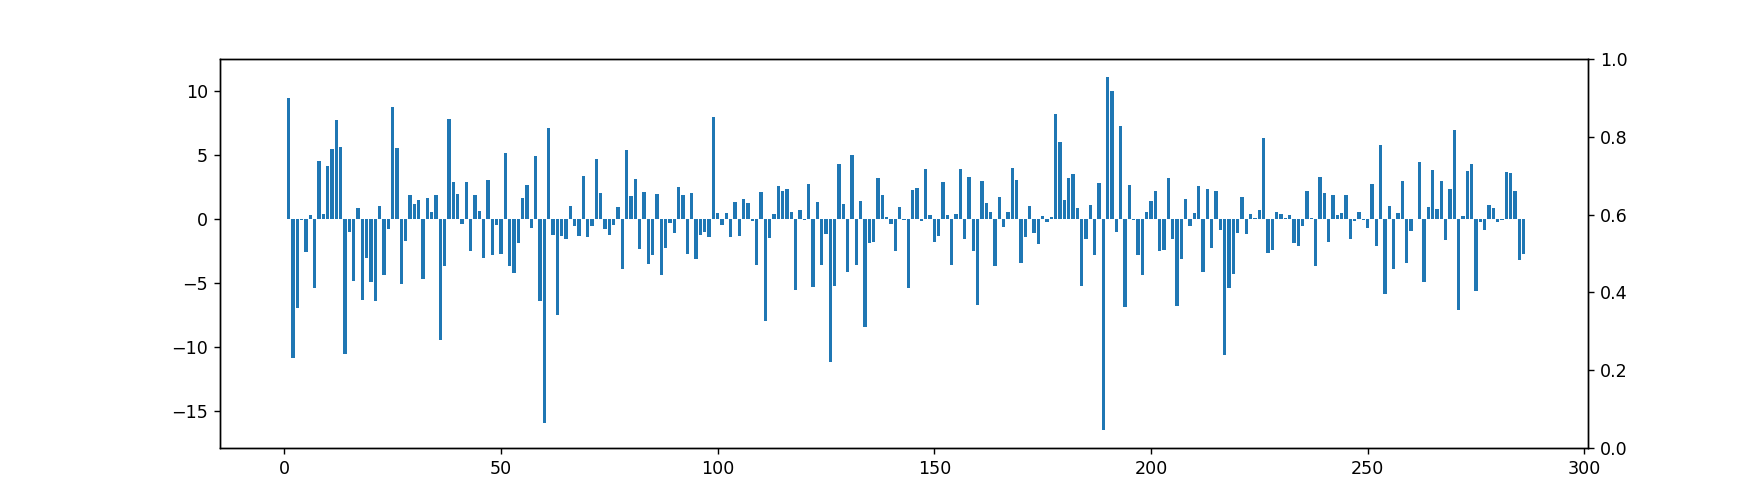

<BarContainer object of 287 artists>

In [453]:
fig, ax = plt.subplots(figsize=(14,4), dpi=70)
ax2 = ax.twinx()

ax.bar(x=list(range(data_full.shape[0])), height=data_full["diff_0.0025"])

In [7]:
key = '0.003038384892933333'

In [9]:
num = float(key)
num

0.003038384892933333

In [11]:
key2 = str(num)
key2

'0.003038384892933333'

In [30]:
keys = ["24.40", "25.12", "20.21", "18.108"]

np.argmin(keys)

3

In [17]:
min(keys)

'18.108'